# HW5
Autoregressive Image Modeling

## Introduction

In this tutorial, we implement an autoregressive likelihood model for the task of image modeling. Autoregressive models are naturally strong generative models that constitute one of the current state-of-the-art architectures on likelihood-based image modeling, and are also the basis for large language generation models such as GPT3. Similar to the language generation autoregressive models work on images by modeling the likelihood of a pixel given all previous ones.
Generally, autoregressive model over high-dimensional data $\mathbf{x}$ factor the joint distribution as the following product of conditionals:
<center width="100%" style="padding: 10px">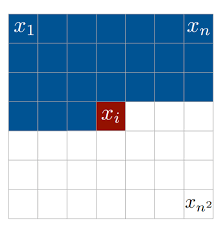</center>


$$p(\mathbf{x})=p(x_1, ..., x_n)=\prod_{i=1}^{n} p(x_i|x_1,...,x_{i-1})$$

Learning these conditionals is often much simpler than learning the joint distribution $p(\mathbf{x})$ all together. However, disadvantages of autoregressive models include slow sampling, especially for large images, as we need height-times-width forward passes through the model. In addition, for some applications, we require a latent space as modeled in VAEs and Normalizing Flows. For instance, in autoregressive models, we cannot interpolate between two images because of the lack of a latent representation.
We will explore and discuss these benefits and drawbacks alongside with our implementation.


## Libraries

In [1]:
%%capture
! pip install torchinfo

In [2]:
## Standard libraries
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim

# Torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

# model information
import torchinfo

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = (
    torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
)
print("Using device", device)

<ipython-input-2-08e245a47d3b>:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


Using device cuda:0


<Figure size 640x480 with 0 Axes>

## Data

In [4]:
def transform_func(img):
    threshold = int(0.33)
    return (img > threshold).float()


transform = transforms.Compose([transforms.ToTensor(), transform_func])

mnist_train = MNIST(root="../data", train=True, transform=transform, download=True)
mnist_test = MNIST(root="../data", train=False, transform=transform, download=True)

train_set, val_set = torch.utils.data.random_split(mnist_train, [50000, 10000])

train_loader = data.DataLoader(
    train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True
)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False)
test_loader = data.DataLoader(
    mnist_test, batch_size=128, shuffle=False, drop_last=False
)

100%|██████████| 9912422/9912422 [00:00<00:00, 265496636.21it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 103094207.51it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 83354120.73it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20797520.49it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



A good practice is to always visualize some data examples to get an intuition of the data:

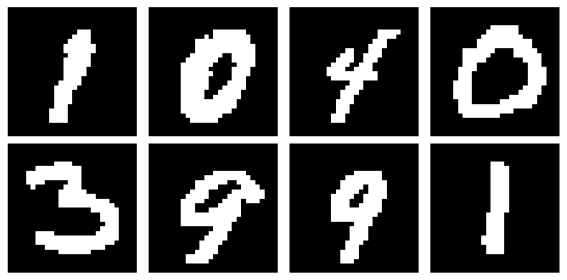

In [5]:
images = [train_set[i][0] for i in range(8)]

fig, axes = plt.subplots(2, 4, figsize=(8, 4))  # 2 rows, 4 columns

for i, tensor in enumerate(images):
    row = i // 4
    col = i % 4
    axes[row, col].imshow(tensor[0], cmap="gray")
    axes[row, col].axis("off")

plt.tight_layout()
plt.show()

## Masked autoregressive convolutions

The core module of PixelCNN is its masked convolutions. In contrast to language models, we don't apply an LSTM on each pixel one-by-one. This would be inefficient because images are grids instead of sequences. Thus, it is better to rely on convolutions that have shown great success in deep CNN classification models.

Nevertheless, we cannot just apply standard convolutions without any changes.
Remember that during training of autoregressive models, we want to use teacher forcing which both helps the model training, and significantly reduces the time needed for training. For image modeling, teacher forcing is implemented by using a training image as input to the model, and we want to obtain as output the prediction for each pixel based on *only* its predecessors.
Thus, we need to ensure that the prediction for a specific pixel can only be influenced by its predecessors and not by its own value or any "future" pixels.
For this, we apply convolutions with a mask.

Which mask we use depends on the ordering of pixels we decide on, i.e. which is the first pixel we predict, which is the second one, etc.
The most commonly used ordering is to denote the upper left pixel as the start pixel, and sort the pixels row by row, as shown in the visualization at the top of the tutorial.
Thus, the second pixel is on the right of the first one (first row, second column), and once we reach the end of the row, we start in the second row, first column.
If we now want to apply this to our convolutions, we need to ensure that the prediction of pixel 1 is not influenced by its own "true" input, and all pixels on its right and in any lower row. In convolutions, this means that we want to set those entries of the weight matrix to zero that take pixels on the right and below into account. As an example for a 5x5 kernel, see a mask below (figure credit - [Aaron van den Oord](https://arxiv.org/pdf/1606.05328.pdf)):

<center width="100%" style="padding: 10px"><img src="https://www.mdpi.com/applsci/applsci-13-10941/article_deploy/html/images/applsci-13-10941-g002.png" width="500px"></center>

Before looking into the application of masked convolutions in PixelCNN in detail, let's first implement a module that allows us to apply an arbitrary mask to a convolution:

In [6]:
class MaskedConvolution(nn.Module):
    def __init__(self, c_in, c_out, mask, **kwargs):
        """
        Implements a convolution with mask applied on its weights.
        Inputs:
            c_in - Number of input channels
            c_out - Number of output channels
            mask - Tensor of shape [kernel_size_H, kernel_size_W] with 0s where
                   the convolution should be masked, and 1s otherwise.
            kwargs - Additional arguments for the convolution
        """
        super().__init__()

        # For simplicity: calculate padding automatically
        kernel_size = (mask.shape[0], mask.shape[1])
        dilation = 1 if "dilation" not in kwargs else kwargs["dilation"]
        padding = tuple([dilation * (kernel_size[i] - 1) // 2 for i in range(2)])

        # Actual convolution
        self.conv = nn.Conv2d(c_in, c_out, kernel_size, padding=padding, **kwargs)

        # Mask as buffer => it is no parameter but still a tensor of the module
        # (must be moved with the devices)
        self.register_buffer("mask", mask[None, None])

    def forward(self, x):

        ## Your code begins

        self.conv.weight.data = self.conv.weight.data * self.mask  # Ensures zero's at masked positions

        ## Your code ends

        return self.conv(x)

In [7]:
class PixelCNNMaskConvolution(MaskedConvolution):
    def __init__(self, c_in, c_out, kernel_size=3, mask_center=False, **kwargs):
        # Mask out all pixels below. For efficiency, we could also reduce the kernel
        # size in height, but for simplicity, we stick with masking here.
        mask = torch.ones(kernel_size, kernel_size)
        center = kernel_size // 2

        ## Your code begins
        mask[center,center+1:] = 0
        mask[center+1:,:] = 0
        ## Your code ends

        # For the very first convolution, we will also mask the center row
        if mask_center:
            mask[center, center] = 0

        super().__init__(c_in, c_out, mask, **kwargs)

Note that we have an input argument called `mask_center`. Remember that the input to the model is the actual input image. Hence, the very first convolution we apply cannot use the center pixel as input, but must be masked. All consecutive convolutions, however, should use the center pixel as we otherwise lose the features of the previous layer. Hence, the input argument `mask_center` is True for the very first convolutions, and False for all others.

## Imlementing PixelCNN

you should implement PixelCNN acording to below diagram

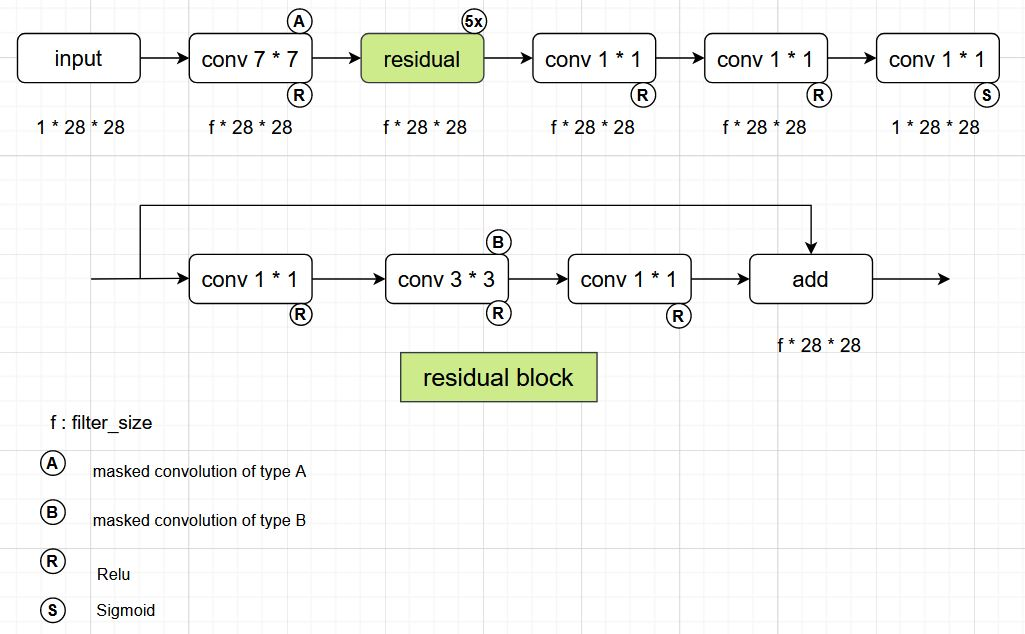


In [8]:
import torch.nn.functional as F


class ResidualBlock(nn.Module):
    def __init__(self, c_in, c_hidden):
        super().__init__()

        self.conv_1 = nn.Conv2d(c_in, c_hidden, kernel_size=1)

        ## Your code begins

        self.conv_pixelcnn = PixelCNNMaskConvolution(c_hidden, c_hidden, kernel_size=3, mask_center=False)

        ## Your code ends

        self.conv_2 = nn.Conv2d(c_hidden, c_hidden, kernel_size=1)

        self.relu = nn.ReLU()


    def forward(self, x):

        ## Your code begins

        out = self.conv_1(x.clone())
        out = self.relu(out)
        out = self.conv_pixelcnn(out)
        out = self.relu(out)
        out = self.conv_2(out)
        out = self.relu(out)
        out = out + x.clone()

        ## Your code ends

        return out


class PixelCNN(nn.Module):
    def __init__(self, c_in, c_hidden, num_res_block=5):
        super().__init__()


        ## Your code begins

        self.conv_pixelcnn = PixelCNNMaskConvolution(c_in, c_hidden, kernel_size=7, mask_center=True)

        self.residual_conv_layers = nn.ModuleList([ResidualBlock(c_hidden, c_hidden) for _ in range(num_res_block)])

        ## Your code ends

        self.conv_1 = nn.Conv2d(c_hidden, c_hidden, kernel_size=1, padding=0)

        self.conv_2 = nn.Conv2d(c_hidden, c_hidden, kernel_size=1, padding=0)

        self.conv_out = nn.Conv2d(c_hidden, 1, kernel_size=1, padding=0)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        """
        Forward image through model and return logits for each pixel.
        Inputs:
            x - Image tensor with integer values between 0 or 1 .
        """
        out = self.conv_pixelcnn(x)
        out = self.relu(out)

        for layer in self.residual_conv_layers:
            out = layer(out)

        out = self.conv_1(out)
        out = self.relu(out)

        out = self.conv_2(out)
        out = self.relu(out)

        out = self.conv_out(out)
        out = self.sigmoid(out)

        # Output dimensions: [Batch, Classes, Channels, Height, Width]
        return out

    @torch.no_grad()
    def sample(self, img_shape, img=None):
        """
        Sampling function for the autoregressive model.
        Inputs:
            img_shape - Shape of the image to generate (B,C,H,W)
            img (optional) - If given, this tensor will be used as
                             a starting image. The pixels to fill
                             should be -1 in the input tensor.
        """
        # Create empty image

        imgs = torch.zeros(img_shape).to(device)

        batch, channels, rows, cols = imgs.shape

        # Iterate over the pixels beceigause generation has to be done sequentially pixel by pixel.
        for row in tqdm(range(rows)):
            for col in range(cols):
                for channel in range(channels):

                    ## Your code begins

                    h = row
                    w = col
                    c = channel
                    pred = self.forward(imgs)
                    probs = F.softmax(pred[:,:,row,col], dim=-1).data
                    imgs[:,:,h,w] = torch.multinomial(probs, num_samples=1).float()

                    ## Your code ends

        return imgs

Summary  ResidualBlock

In [9]:
c_in_channels = 128
c_hidden_channels = 128
res_block = ResidualBlock(c_in_channels, c_hidden_channels)

batch_size = 128

input_shape = (batch_size, c_in_channels, 28, 28)
torchinfo.summary(model=res_block, input_size=input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
ResidualBlock                            [128, 128, 28, 28]        --
├─Conv2d: 1-1                            [128, 128, 28, 28]        16,512
├─ReLU: 1-2                              [128, 128, 28, 28]        --
├─PixelCNNMaskConvolution: 1-3           [128, 128, 28, 28]        --
│    └─Conv2d: 2-1                       [128, 128, 28, 28]        147,584
├─ReLU: 1-4                              [128, 128, 28, 28]        --
├─Conv2d: 1-5                            [128, 128, 28, 28]        16,512
├─ReLU: 1-6                              [128, 128, 28, 28]        --
Total params: 180,608
Trainable params: 180,608
Non-trainable params: 0
Total mult-adds (G): 18.12
Input size (MB): 51.38
Forward/backward pass size (MB): 308.28
Params size (MB): 0.72
Estimated Total Size (MB): 360.38

Summary of PixelCNN

In [10]:
c_in_channels = 1
c_hidden_channels = 128

pixelcnn = PixelCNN(c_in_channels, c_hidden_channels)

batch_size = 128

input_shape = (batch_size, c_in_channels, 28, 28)

torchinfo.summary(model=pixelcnn, input_size=input_shape)

Layer (type:depth-idx)                        Output Shape              Param #
PixelCNN                                      [128, 1, 28, 28]          --
├─PixelCNNMaskConvolution: 1-1                [128, 128, 28, 28]        --
│    └─Conv2d: 2-1                            [128, 128, 28, 28]        6,400
├─ReLU: 1-2                                   [128, 128, 28, 28]        --
├─ModuleList: 1-3                             --                        --
│    └─ResidualBlock: 2-2                     [128, 128, 28, 28]        --
│    │    └─Conv2d: 3-1                       [128, 128, 28, 28]        16,512
│    │    └─ReLU: 3-2                         [128, 128, 28, 28]        --
│    │    └─PixelCNNMaskConvolution: 3-3      [128, 128, 28, 28]        147,584
│    │    └─ReLU: 3-4                         [128, 128, 28, 28]        --
│    │    └─Conv2d: 3-5                       [128, 128, 28, 28]        16,512
│    │    └─ReLU: 3-6                         [128, 128, 28, 28]        --
│   

## Training PixelCNN

In [13]:
c_in_channels = 1
c_hidden_channels = 128

model = PixelCNN(c_in_channels, c_hidden_channels)
model.to(device)
criterion = nn.BCELoss() # Use reconstruction loss (e.g., BCE)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training loop
num_epochs = 50
for epoch in tqdm(range(num_epochs), desc="epoch"):
    model.train()
    running_loss = 0.0

    for data, _ in tqdm(train_loader, desc="batch", leave=False):
        data = data.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(
        f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {running_loss / len(train_loader):.4f}"
    )
    running_loss = 0.0

    # Validation loop (optional)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, _ in val_loader:
            data = data.to(device)
            outputs = model(data)
            loss = criterion(outputs, data)
            val_loss += loss.item()

    val_loss /= len(test_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Val Loss: {val_loss:.4f}")

epoch:   0%|          | 0/50 [00:00<?, ?it/s]

batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 0.1296
Epoch [1/50], Val Loss: 0.0932


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [2/50], Train Loss: 0.0924
Epoch [2/50], Val Loss: 0.0910


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [3/50], Train Loss: 0.0905
Epoch [3/50], Val Loss: 0.0892


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [4/50], Train Loss: 0.0889
Epoch [4/50], Val Loss: 0.0883


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [5/50], Train Loss: 0.0879
Epoch [5/50], Val Loss: 0.0873


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [6/50], Train Loss: 0.0872
Epoch [6/50], Val Loss: 0.0867


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [7/50], Train Loss: 0.0867
Epoch [7/50], Val Loss: 0.0866


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [8/50], Train Loss: 0.0863
Epoch [8/50], Val Loss: 0.0865


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [9/50], Train Loss: 0.0860
Epoch [9/50], Val Loss: 0.0861


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [10/50], Train Loss: 0.0856
Epoch [10/50], Val Loss: 0.0854


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [11/50], Train Loss: 0.0853
Epoch [11/50], Val Loss: 0.0852


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [12/50], Train Loss: 0.0849
Epoch [12/50], Val Loss: 0.0849


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [13/50], Train Loss: 0.0848
Epoch [13/50], Val Loss: 0.0853


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [14/50], Train Loss: 0.0844
Epoch [14/50], Val Loss: 0.0844


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [15/50], Train Loss: 0.0843
Epoch [15/50], Val Loss: 0.0843


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [16/50], Train Loss: 0.0840
Epoch [16/50], Val Loss: 0.0845


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [17/50], Train Loss: 0.0838
Epoch [17/50], Val Loss: 0.0841


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [18/50], Train Loss: 0.0836
Epoch [18/50], Val Loss: 0.0837


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [19/50], Train Loss: 0.0834
Epoch [19/50], Val Loss: 0.0835


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.0833
Epoch [20/50], Val Loss: 0.0835


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [21/50], Train Loss: 0.0832
Epoch [21/50], Val Loss: 0.0833


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [22/50], Train Loss: 0.0830
Epoch [22/50], Val Loss: 0.0831


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [23/50], Train Loss: 0.0828
Epoch [23/50], Val Loss: 0.0830


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [24/50], Train Loss: 0.0827
Epoch [24/50], Val Loss: 0.0830


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [25/50], Train Loss: 0.0826
Epoch [25/50], Val Loss: 0.0832


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [26/50], Train Loss: 0.0825
Epoch [26/50], Val Loss: 0.0827


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [27/50], Train Loss: 0.0823
Epoch [27/50], Val Loss: 0.0829


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [28/50], Train Loss: 0.0822
Epoch [28/50], Val Loss: 0.0827


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [29/50], Train Loss: 0.0822
Epoch [29/50], Val Loss: 0.0826


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [30/50], Train Loss: 0.0820
Epoch [30/50], Val Loss: 0.0828


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [31/50], Train Loss: 0.0819
Epoch [31/50], Val Loss: 0.0824


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [32/50], Train Loss: 0.0818
Epoch [32/50], Val Loss: 0.0823


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [33/50], Train Loss: 0.0817
Epoch [33/50], Val Loss: 0.0823


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [34/50], Train Loss: 0.0816
Epoch [34/50], Val Loss: 0.0822


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [35/50], Train Loss: 0.0816
Epoch [35/50], Val Loss: 0.0822


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [36/50], Train Loss: 0.0815
Epoch [36/50], Val Loss: 0.0822


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [37/50], Train Loss: 0.0814
Epoch [37/50], Val Loss: 0.0824


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [38/50], Train Loss: 0.0813
Epoch [38/50], Val Loss: 0.0821


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [39/50], Train Loss: 0.0812
Epoch [39/50], Val Loss: 0.0821


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [40/50], Train Loss: 0.0811
Epoch [40/50], Val Loss: 0.0821


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [41/50], Train Loss: 0.0811
Epoch [41/50], Val Loss: 0.0820


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [42/50], Train Loss: 0.0810
Epoch [42/50], Val Loss: 0.0819


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [43/50], Train Loss: 0.0809
Epoch [43/50], Val Loss: 0.0822


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [44/50], Train Loss: 0.0808
Epoch [44/50], Val Loss: 0.0819


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [45/50], Train Loss: 0.0807
Epoch [45/50], Val Loss: 0.0821


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [46/50], Train Loss: 0.0807
Epoch [46/50], Val Loss: 0.0820


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [47/50], Train Loss: 0.0806
Epoch [47/50], Val Loss: 0.0819


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [48/50], Train Loss: 0.0805
Epoch [48/50], Val Loss: 0.0820


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [49/50], Train Loss: 0.0805
Epoch [49/50], Val Loss: 0.0819


batch:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [50/50], Train Loss: 0.0804
Epoch [50/50], Val Loss: 0.0820


## Sampling

One way of qualitatively analysing generative models is by looking at the actual samples.
Let's therefore use our sampling function to generate a few digits:

  0%|          | 0/28 [00:00<?, ?it/s]

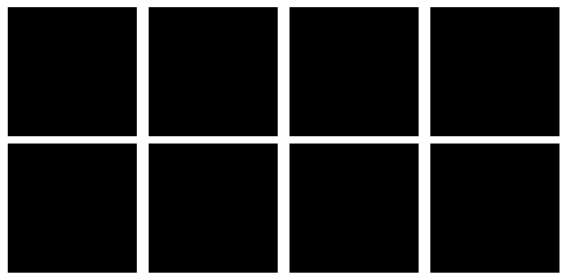

In [15]:
samples = model.sample(img_shape=(8, 1, 28, 28)).cpu()

fig, axes = plt.subplots(2, 4, figsize=(8, 4))  # 2 rows, 4 columns

for i, tensor in enumerate(samples):
    row = i // 4
    col = i % 4
    axes[row, col].imshow(tensor[0], cmap="gray")
    axes[row, col].axis("off")

plt.tight_layout()
plt.show()

## PixelCNN suffers from blind spot

**PixelCNN faces the challenge of a blind spot**, an issue we're keen on investigating further. While there exist additional papers that have successfully tackled this problem, our current focus lies solely on exploring and understanding this particular challenge without delving into the analysis of those solutions.

**what is receptive field of a convolution layer ?**

The receptive field of a convolutional layer refers to the area of the input data that affects the activation of a particular neuron in that layer. In simpler terms, it represents the region in the input space that contributes to the calculation of a feature at a given layer in a convolutional neural network (CNN).

**You are now required to anlyze the following code snippets and answer to the provided question**

### Visualizing the receptive field


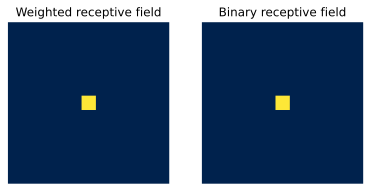

In [16]:
inp_img = torch.zeros(1, 1, 11, 11)
inp_img.requires_grad_()


def show_center_recep_field(img, out):
    """
    Calculates the gradients of the input with respect to the output center pixel,
    and visualizes the overall receptive field.
    Inputs:
        img - Input image for which we want to calculate the receptive field on.
        out - Output features/loss which is used for backpropagation, and should be
              the output of the network/computation graph.
    """
    # Determine gradients
    loss = out[0, :, img.shape[2] // 2, img.shape[3] // 2].sum()
    loss.backward(
        retain_graph=True
    )  # Retain graph as we want to stack multiple layers and show the receptive field of all of them
    img_grads = img.grad.abs()
    img.grad.fill_(0)  # Reset grads

    # Plot receptive field
    img = img_grads.squeeze().cpu().numpy()
    fig, ax = plt.subplots(1, 2)
    pos = ax[0].imshow(img)
    ax[1].imshow(img > 0)
    # Mark the center pixel in red if it doesn't have any gradients (should be the case for standard autoregressive models)
    show_center = img[img.shape[0] // 2, img.shape[1] // 2] == 0

    if show_center:
        center_pixel = np.zeros(img.shape + (4,))
        center_pixel[
            center_pixel.shape[0] // 2, center_pixel.shape[1] // 2, :
        ] = np.array([1.0, 0.0, 0.0, 1.0])

    for i in range(2):
        ax[i].axis("off")
        if show_center:
            ax[i].imshow(center_pixel)

    ax[0].set_title("Weighted receptive field")
    ax[1].set_title("Binary receptive field")
    plt.show()
    plt.close()


show_center_recep_field(inp_img, inp_img)

Layer 2


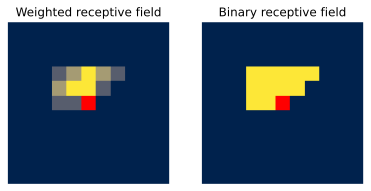

Layer 3


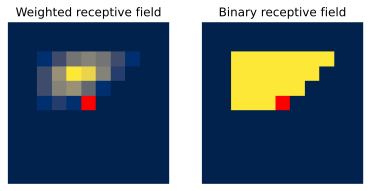

Layer 4


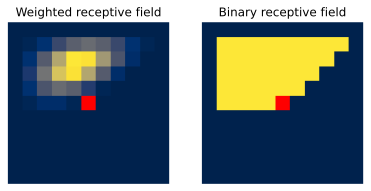

Layer 5


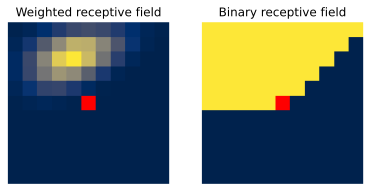

In [17]:
# Initialize convolutions with equal weight to all input pixels

inp_img = torch.zeros(1, 1, 11, 11)
inp_img.requires_grad_()

pixel_cnn_conv = PixelCNNMaskConvolution(
    c_in=1, c_out=1, kernel_size=3, mask_center=True
)
pixel_cnn_conv.conv.weight.data.fill_(1)
pixel_cnn_conv.conv.bias.data.fill_(0)
pi_cnn_img = pixel_cnn_conv(inp_img)

pixel_cnn_conv = PixelCNNMaskConvolution(
    c_in=1, c_out=1, kernel_size=3, mask_center=False
)
pixel_cnn_conv.conv.weight.data.fill_(1)
pixel_cnn_conv.conv.bias.data.fill_(0)

# We reuse our convolutions for the 4 layers here. Note that in a standard network,
# we don't do that, and instead learn 4 separate convolution. As this cell is only for
# visualization purposes, we reuse the convolutions for all layers.
for l_idx in range(4):
    pi_cnn_img = pixel_cnn_conv(pi_cnn_img)
    print(f"Layer {l_idx+2}")
    show_center_recep_field(inp_img, pi_cnn_img)

### Answer to a Question


<font color = "green" >**Question :** </font>

What's the problem with the receptive field around the center red pixel? Explain .

This occurs due to the use of masked convolutions, which restrict the information flow from future pixels to the current pixel being predicted. As a result, the model may not have access to all the necessary information to make accurate predictions, leading to a blind spot in its receptive field. This problem has been addressed in the literature through various techniques, such as the use of horizontal and vertical stacks, gated blocks, and global conditioning, to ensure that all relevant pixels are taken into account during the prediction process